# SMBH luminosity function

Juan Urrutia, December 2025

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator,interp1d,LinearNDInterpolator
from scipy.integrate import quad, fixed_quad, quadrature, simps, romberg, trapezoid, nquad
from scipy.optimize import root_scalar
from scipy.interpolate import BSpline, make_interp_spline
from IPython.display import display, Math

## General Cosmology

In [2]:
#Constants
kpc=1;
s=1;
kg=1;
meter = 3.24e-20*kpc;
G = 6.674e-11*meter**3/kg/s**2;
c = 2.998e8*meter/s;
Msun = 1.99e30*kg;
h = 0.674;
𝛔8 = 0.811;
ΩM = 0.315;
Ωb = 0.0493;
zeq = 3402;
T0 = 2.7255;
ns = 0.965;

#Densities

def solve_Omega_R():
    return ΩM * (1 + zeq)**3 / (1 + zeq)**4    
ΩR = solve_Omega_R()
ΩL = 1 - ΩM - ΩR
Ωc = ΩM - Ωb
H0 = 100 * h * meter
def AH(z):
    return np.sqrt(ΩM * (1 + z)**3 + ΩR * (1 + z)**4 + ΩL)
def H(z):
    return H0 * AH(z)
def ΩMz(z):
    return ΩM * (1 + z)**3 / AH(z)**2
def ΩLz(z):
    return ΩL / AH(z)**2
𝜌c = 3 * H0**2 / (8 * np.pi * G)
Ω0 = 0.32
Ωb = 0.05
𝜌0 = Ω0 * 277.5 * h**2
𝜌M0 = 𝜌c * ΩM / Msun * kpc**3
keq = H(zeq)/(1+zeq)*kpc/c;

# Distances
z_grid = np.arange(-6, 4.01, 0.01)
z_vals = 10 ** z_grid
dc_points = []
for z in z_vals:
    if z == 0:
        dc_points.append(0)
    else:
        integrand = lambda x: c / H(x) / kpc
        val, _ = quad(integrand, 0, z)
        dc_points.append(val)
dc = interp1d(z_vals, dc_points, kind='linear', fill_value="extrapolate")

def DVc(z):
    dz = 1e-5
    dcdz = (dc(z + dz) - dc(z- dz)) / (2*dz)
    return 4 * np.pi * dc(z)**2 * dcdz
    
def zDLf(DL):
    def func(z):
        return (1 + z) * dc(z) - DL
    sol = root_scalar(func, bracket=[0, 2e3], method='brentq')
    return sol.root if sol.converged else np.nan
def DLz(z):
    return (1 + z) * dc(z)
    
def tza(z):
    integrand = lambda x: 1 / ((1 + x) * H(x))
    return quad(integrand, z, np.inf)[0]
tz_points = np.concatenate([np.linspace(-0.999, 0, 200), np.linspace(0.0001, 100, 300)])
tz_vals = [tza(z) for z in tz_points]
tz = interp1d(tz_points, tz_vals, kind='cubic', fill_value="extrapolate")
zt = interp1d(tz_vals, tz_points, kind='cubic', fill_value="extrapolate")

#Growth of perturbations

def Dg(z):
    return 5/2*ΩMz(z)/(ΩMz(z)**(4/7)-ΩLz(z)+(1+ΩMz(z)/2)*(1+ΩLz(z)/70))/(1+z)/0.78694
def 𝛿(z):
    return 3 * (12 * np.pi)**(2/3) / 20 * (1 + 0.123 * np.log10(ΩL * (1 + z)**3 / (ΩL * (1 + z)**3 + 1 -ΩL)))
def 𝛿c(z):
    return 3 / 5 * (3 * np.pi / 2)**(2/3) / Dg(z)

In [5]:
# Matter power spectrum

def T(kk):
    ksilk = 1.6 * (Ωb * h**2)**0.52 * (ΩM * h**2)**0.73 * (1 + (10.4 * ΩM * h**2)**-0.95) / 1e3
    a1 = (46.9 * ΩM * h**2)**0.67 * (1 + (32.1 * ΩM * h**2)**-0.532)
    a2 = (12.0 * ΩM * h**2)**0.424 * (1 + (45.0 * ΩM * h**2)**-0.582)
    b1 = 0.944 * (1 + (458 * ΩM * h**2)**-0.708)**-1
    b2 = (0.395 * ΩM* h**2)**(-0.026)
    alpha_cnum = a1**(-Ωb / ΩM) * a2**(-(Ωb / ΩM)**3)
    beta_cnum = 1 / (1 + b1 * ((Ωc / ΩM)**b2 - 1))
    def q(k): return k / (13.41 * keq)
    def C1(k, alpha_c): return 14.2 / alpha_c + 386 / (1 + 69.9 * q(k)**1.08)
    def To1(k, alpha_c, beta_c): return np.log(np.e + 1.8 * beta_c * q(k)) / (np.log(np.e + 1.8 * beta_c * q(k)) + C1(k, alpha_c) * q(k)**2)
    s2 = 44.5 * np.log(9.83 / (ΩM * h**2)) / np.sqrt(1 + 10 * (Ωb * h**2)**(3/4)) * 1e3
    def f(k): return 1 / (1 + (k * s2 / 5.4)**4)
    def Tc(k): return f(k) * To1(k, 1, beta_cnum) + (1 - f(k)) * To1(k, alpha_cnum, beta_cnum)
    def jo(x): return np.sin(x) / x
    def g2(y): return y * (-6 * np.sqrt(1 + y) + (2 + 3 * y) * np.log((np.sqrt(1 + y) + 1) / (np.sqrt(1 + y) - 1)))
    zeq = 2.50e4 * ΩM * h**2 * (T0 / 2.7)**-4
    b3 = 0.313 * (ΩM * h**2)**-0.419 * (1 + 0.607 * (ΩM * h**2)**0.674)
    b4 = 0.238 * (ΩM * h**2)**0.223
    zd = 1291 * (ΩM * h**2)**0.251 / (1 + 0.659 * (ΩM * h**2)**0.828) * (1 + b3 * (Ωb * h**2)**b4)
    Rd = 31.5 * Ωb * h**2 * (T0 / 2.7)**-4 * (zd / 1e3)**-1
    alpha_b = 2.07 * keq * s2 * (1 + Rd)**(-3/4) * g2((1 + zeq) / (1 + zd))
    beta_b = 0.5 + Ωb / ΩM + (3 - 2 * Ωb / ΩM) * np.sqrt(1 + (17.2 * ΩM * h**2)**2)
    beta_node = 8.41 * (ΩM * h**2)**0.435
    def s3(k): return s2 / (1 + (beta_node / (k * s2))**3)**(1/3)
    def Tb(k): return (To1(k, 1, 1) / (1 + (k * s2 / 5.2)**2) + alpha_b / (1 + (beta_b / (k * s2))**3) * np.exp(-(k / ksilk)**1.4)) * jo(k * s3(k))
    return Ωb / ΩM * Tb(kk) + Ωc / ΩM * Tc(kk)
    
def CapitalDelta(k):
    delta_h = 0.00005
    return np.sqrt(delta_h**2 * (c * k / H0)**(3 + ns) * np.abs(T(k))**2)

def P(k):
    return CapitalDelta(k)**2 * (2 * np.pi**2) / k**3

def j1(x):
    return (x * np.cos(x) - np.sin(x)) / x**2

R8 = 8 / h * 1e3

### DM dependent terms

In [6]:
# Matter density variance in CDM 
def WFT(x):
   return 3*(np.sin(x)-x*np.cos(x))/(x**3)
def 𝛔f(M):
    def r(Mc):
        return (3*Mc/(4*np.pi*𝜌M0))**(1/3)
    val, _ = quad(lambda logk:10**(3*logk) * WFT(r(M)*10**logk)**2 * P(10**logk), -20, 20, epsrel=1e-2)
    return 1/(np.sqrt(2)*np.pi) * np.sqrt(np.log(10)*val)
    
log10m_vals = np.arange(-16, 32.1, 0.1)
m_vals = 10**log10m_vals
𝛔2_vals = np.array([𝛔f(m) for m in m_vals])
𝛔2_interp = make_interp_spline(m_vals, 𝛔2_vals, k=1)
def 𝛔CDM2(M):
    ref_mass = 2.7803939422903778e14
    return 𝛔8 / 𝛔2_interp(ref_mass) * 𝛔2_interp(M)
𝛔CDM_vals = np.array([𝛔CDM2(m) for m in m_vals])
𝛔CDM = make_interp_spline(m_vals,𝛔CDM_vals, k=1)
d𝛔dM= 𝛔CDM.derivative()

## GW physics

In [ ]:
# Arrays
a1 = np.array([2.97e-1, 5.94e-1, 5.08e-1, 8.48e-1])
b1 = np.array([4.48e-2, 8.97e-2, 7.75e-2, 1.28e-1])
c1 = np.array([9.55e-2, 1.91e-1, 2.23e-2, 2.72e-1])

# Functions
def fRD(Mchirp, eta):
    return c**3 * eta**(3/5) / (6**(3/2) * np.pi * G * Mchirp * Msun) * s

def tins(f, Mchirp):
    return (5 * c**5) / (256 * (np.pi * f / s)**(8/3) * (G * Mchirp * Msun)**(5/3)) * s**(-1)

def finspiral(t, Mchirp):
    return (5**(3/8) * c**(15/8) * s) / (8 * (G * Mchirp * Msun)**(5/8) * np.pi * (t * s)**(3/8))

def fmerg(Mchirp, eta):
    return s * c**3 / G * (a1[0]*eta**2 + b1[0]*eta + c1[0]) / (np.pi * (Mchirp * Msun) * eta**(-3/5))

def fring(Mchirp, eta):
    return s * c**3 / G * (a1[1]*eta**2 + b1[1]*eta + c1[1]) / (np.pi * (Mchirp * Msun) * eta**(-3/5))

def Sigma3(Mchirp, eta):
    return s * c**3 / G * (a1[2]*eta**2 + b1[2]*eta + c1[2]) / (np.pi * (Mchirp * Msun) * eta**(-3/5))

def fcut(Mchirp, eta):
    return s * c**3 / G * (a1[3]*eta**2 + b1[3]*eta + c1[3]) / (np.pi * (Mchirp * Msun) * eta**(-3/5))

def fbeg(Mchirp, DsL):
    return s * (c**(-5) * 256 * np.pi**(8/3) * (G * Mchirp * Msun)**(5/3) * (yr/second * s) / 5) ** (-3/8)

def fday(Mchirp):
    return s * (c**(-5) * 256 * np.pi**(8/3) * (G * Mchirp * Msun)**(5/3) * (86400 * s) / 5) ** (-3/8)

def fyear(Mchirp):
    return s * (c**(-5) * 256 * np.pi**(8/3) * (G * Mchirp * Msun)**(5/3) * (yr/second * s) / 5) ** (-3/8)

def fyearn(n, Mchirp):
    return s * (c**(-5) * 256 * np.pi**(8/3) * (G * Mchirp * Msun)**(5/3) * (n * yr/second * s) / 5) ** (-3/8)

def fmrc(Mchirp, eta, f):
    fm = fmerg(Mchirp, eta)
    fr = fring(Mchirp, eta)
    fc = fcut(Mchirp, eta)
    term1 = f**(-7/6)
    term2 = fm**(-1/2) * f**(-2/3)
    term3 = fm**(-1/2) * fr**(-2/3) * (sigma(Mchirp, eta)**2) / (4 * (f - fr)**2 + Sigma3(Mchirp, eta)**2)
    return np.where(f < fm, term1,
                    np.where(f < fr, term2,
                             np.where(f < fc, term3, np.nan)))

def ft(t, Mc, z):
    return (5**(3/8) * c**(15/8) * s) / (8 * (G * Mc * Msun)**(5/8) * np.pi * (1 + z) * (t/(1+z))**(3/8))

def McEta(m1, m2):
    return {
        'Mc': (m1 * m2)**(3/5) / (m1 + m2)**(1/5),
        'eta': (m1 * m2) / (m1 + m2)**2
    }

def MtEta(m1, m2):
    return {
        'Mt': (m1 + m2),
        'eta': (m1 * m2) / (m1 + m2)**2
    }

def McEta2(M, q):
    m1 = M / (1 + q)
    m2 = q * M / (1 + q)
    return {
        'Mc': (m1 * m2)**(3/5) / (m1 + m2)**(1/5),
        'eta': (m1 * m2) / (m1 + m2)**2,
        'm1': m1,
        '


## EPS structure formation and merger rates

In [10]:
#Basic probabilities 

def pfcST(δ1,S1): return 0.114963*S1**(-3/2)*np.e**(-0.4*δ1**2/S1)*δ1*(1+1.06923*(δ1**2/S1)**(-3/10))
def δel(δ1,S1): return np.sqrt(0.707)*δ1*(1+0.485*(0.707*δ1**2/S1)**(-0.615))
def pfc(δ1,S1,δ2,S2): 
    return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
def pcond(δp,𝛔p,δm,𝛔m):
    return pfc(δp,𝛔p**2,δm,𝛔m**2)*pfcST(δm,𝛔m**2)/pfcST(δp,𝛔p**2)
#halo mass functions
def dndlogm(M,z):
    return 𝜌0*2*𝛔CDM(M)*np.abs(d𝛔dM(M))*pfcST(δc(z),𝛔CDM(M)**2)

In [11]:
# CDM merger rate in elliptical collapse
def Rloglog(M1, M2, z, Δz):
    Mp = min(M1, M2)
    M = M1 + M2
    return dndlogm(Mp,z+Δz)*(1+z)*H(z)/(Δz)*2*𝛔CDM(M)*M*np.abs(d𝛔dM(M))*pcond(δc(z+Δz), 𝛔CDM(Mp), δc(z), 𝛔CDM(M))

In [ ]:
# We first compute the stellar halo mass relation, 

def Az(z):
    return 0.046 * (1.0 + z) ** (-0.38)

def logMaz(z):
    return 11.79 + 0.2 * z

def Gamma_z(z):
    return 0.709 * (1.0 + z) ** (-0.18)

def Beta_z(z):
    return 0.043 * z + 0.92

def Mstar(Mh, z):
    denom = (Mh / (10.0 ** logMaz(z))) ** (-Beta_z(z)) + (Mh / (10.0 ** logMaz(z))) ** (Gamma_z(z))
    return 2.0 * Az(z) * Mh * (denom ** (-1.0))

def Mbulge(mstar):
    return 0.615 * mstar

def logMBH(Mh, z, a, b, c, z2):
    Ms = Mstar(Mh, z)
    return a + b * np.log10(Ms / (10.0 ** 11)) + c * np.log10(1.0 + z)

def logMh(MBH, z, a, b, c):
    def f(Mh):
        return logMBH(Mh, z, a, b, c, z) - np.log10(MBH)
    Mh_root = optimize.newton(f, np.log10(MBH) + 2.0)
    return np.log10(Mh_root)

# We then connect the 
def pMBH(mbh, Mh, z, a, b, c, sigma):
    mu = logMBH(Mh, z, a, b, c, z)
    return stats.norm.pdf(np.log10(mbh), loc=mu, scale=sigma)

def logmvMin(mbh, z, a, b, c, sigma):
    def g(x):
        return np.log10(pMBH(mbh, x, z, a, b, c, sigma)) + 3.0
    x_root = optimize.brentq(g, 1.0, 1.0e18)
    return np.log10(x_root)



## Nanograv data and SMBH data

In [ ]:
prob = np.load(NotebookDirectory() + "30f_fs{hd}_ceffyl/density.npy")
L10rho = np.load(NotebookDirectory() + "30f_fs{hd}_ceffyl/log10rhogrid.npy")
fNG15 = np.load(NotebookDirectory() + "30f_fs{hd}_ceffyl/freqs.npy")
DeltafNG15 = np.diff(fNG15)[0]

data = [np.vstack((L10rho, np.exp(prob[j]))).T for j in range(prob.shape[0])]

def OmegaGW(DeltaT, f):
    return 8 * np.pi**4 * (DeltaT**2) * (f**5) * (16.03 * year) / (s * H0)**2

PNG15_interp = [interpolate.interp1d(d[:,0], d[:,1], kind='linear', bounds_error=False, fill_value=0.0) for d in data]

class ProbabilityDistribution:
    def __init__(self, pdf_func, a, b):
        self.pdf = pdf_func
        self.a = a
        self.b = b

def _normalize_pdf(pdf_func, a, b, n=10000):
    xs = np.linspace(a, b, n)
    vals = pdf_func(xs)
    area = np.trapz(vals, xs)
    if area == 0:
        return lambda x: 0*x
    return lambda x: pdf_func(x) / area

PNG15 = [ProbabilityDistribution(_normalize_pdf(PNG15_interp[i], data[i][0,0], data[i][-1,0]), data[i][0,0], data[i][-1,0]) for i in range(len(PNG15_interp))]
PNG15 = list(zip(fNG15, PNG15))
PNG15 = PNG15[:14]

def RandomVariate(Pdist, size):
    a, b = Pdist.a, Pdist.b
    xs_grid = np.linspace(a, b, 10000)
    pdf_vals = Pdist.pdf(xs_grid)
    M = np.max(pdf_vals)
    samples = []
    rng = np.random.default_rng()
    while len(samples) < size:
        x_prop = rng.uniform(a, b, size - len(samples))
        u = rng.uniform(0, M, size - len(samples))
        accept = u < Pdist.pdf(x_prop)
        samples.extend(x_prop[accept])
    return np.array(samples)

def findlogOmegaDist(Pf):
    f = Pf[0]
    Pdist = Pf[1]
    rv = RandomVariate(Pdist, 5_000_000)
    y = np.log10(OmegaGW(10.0**rv, f))
    bins = np.round(y / 0.01) * 0.01
    uniq, counts = np.unique(bins, return_counts=True)
    dens = counts * (0.01 / 5_000_000.0)
    return interpolate.interp1d(uniq, dens, kind='nearest', bounds_error=False, fill_value=0.0)

PNG15logOmega = []
for j in range(len(PNG15)):
    f, Pdist = PNG15[j]
    interp0 = findlogOmegaDist(PNG15[j])
    xmin = np.min(interp0.x)
    xmax = np.max(interp0.x)
    PNG15logOmega.append((f, ProbabilityDistribution(_normalize_pdf(interp0, xmin, xmax), xmin, xmax)))

data1 = Import(NotebookDirectory() + "Broad_line_AGNs.rtf", "Table")
data2 = Import(NotebookDirectory() + "AGNs.rtf", "Table")

broadLINEAGNdata = []
broadLINEAGNdata.append([[data1[9][9], "".join(list(data1[9][10])[:4])], [0.3, 0.5]])
for j in range(11, 254):
    row = data1[j-1]
    broadLINEAGNdata.append([[row[7], "".join(list(row[8])[:4])], [0.3, 0.5]])

otherAGNdata = []
for j in range(10, 37):
    row = data2[j-1]
    val_str = row[len(row)-1]
    val = float("".join(list(val_str)[:len(list(val_str))-1]))
    otherAGNdata.append([[row[len(row)-3], row[len(row)-2]], [0.3, max([val, 0.01])], 0])

dynamicallymeasured = []
for j in range(37, 116):
    row = data2[j-1]
    val_str = row[len(row)-1]
    val = float("".join(list(val_str)[:len(list(val_str))-1]))
    dynamicallymeasured.append([[row[len(row)-3], row[len(row)-2]], [0.3, max([val, 0.01])], 0])

## Baryonic physics and differential evolution

In [ ]:
#SMBH accretion parameters

TauEd = 7 * 10**(-16)

def MEd(z2, z1, mbh, fr):
    return mbh * (np.exp(fr * TauEd * (tz(z2) - tz(z1)) * s) - 1.0)

#Galactic internal feedbacks 

def feedback(M, Mc, alpha, beta, Mt):
    return (alpha + beta) / (beta * (M / Mc)**(-alpha) + alpha * (M / Mc)**(beta)) * np.exp(-Mt / M)

def fstar(M, Mc, alpha, beta, fstarmax, Mt):
    return np.where(M < Mc, fstarmax * feedback(M, Mc, alpha, beta, Mt), fstarmax)

def fcold(M, Mc, alpha, beta, fstarmax, Mt):
    return np.where(M >= Mc, feedback(M, Mc, alpha, beta, Mt), 1.0)

def fejj(M, Mc, alpha, beta, fstarmax, Mt, fejSN):
    base = (1.0 - fejSN) * (1.0 - fstar(M, Mc, alpha, beta, fstarmax, Mt))
    return np.where(M <= Mc, base, base * fcold(M, Mc, alpha, beta, fstarmax, Mt)**2)

def frem(M, Mc, alpha, beta, fstarmax, Mt, fejSN):
    return 1.0 - (fejj(M, Mc, alpha, beta, fstarmax, Mt, fejSN) + fstar(M, Mc, alpha, beta, fstarmax, Mt)) * fcold(M, Mc, alpha, beta, fstarmax, Mt)

In [ ]:
#These come from fitting the UV-luminosity function 

def ratio(zs): return (22.9 - zs) / (22.9 - 12.7)
def alpha(zs): return min(0.91, 0.91 * max(0.0, ratio(zs)))
def beta(zs): return min(0.4,  0.4  * max(0.0, ratio(zs))) 
Mc1 = 4e11
M0    = 10 ** 7.9
fstarmax = 0.39

#some initial condition functions

def nl(logm, logmax, dlogm):
    n_steps = int((logmax - dlogm - logm) / dlogm)
    return np.array([logm + i * dlogm for i in range(n_steps + 1)])
def nstar(logm, logmax, dlogm, z):
    return np.array([
        np.log(10) * (Ωb / ΩM) * fstar(10 ** (logm), Mc1, alpha(z), beta(z), fstarmax, M0)
        * 10 ** (logm)
        for logm in nl(logm, logmax, dlogm)
    ])
def nMSeed(logm, logmax, dlogm, logmseed, Mseed):
    n_steps = int((logmax - dlogm - logm) / dlogm)
    out = []
    for i in range(n_steps + 1):
        val = ((dlogm - logmseed) * Mseed) / dlogm + (Mseed / dlogm) * (logm + i * dlogm)
        out.append(max(0.0, min(val, Mseed)))
    return np.array(out)

In [ ]:
# differential evolution in CDM 
def ACDM(zs, zb, logm, logmax, dlogm, nSMBH, nStar, facbh1, facbh2, fsn, fed, pbh):
    
    masses = 10 ** nl(logm, logmax, dlogm) 
    nSform = np.array([
    np.abs(np.abs(zs - zb)*fcold(m, Mc1, alpha(zs), beta(zs), fstarmax, M0)*fstar(m, Mc1, alpha(zs), beta(zs), fstarmax, M0)*(Ωb / ΩM)*dMdz(m, zb))
    for m in masses
    ])

    nSMBHacc = np.array([
        min(
            np.abs((Ωb / ΩM)*frem(m, Mc1, alpha(zs), beta(zs), fstarmax, M0, fsn)*(facbh1 * np.abs(zs - zb) * dMdz(m, zb) + (tz(zs) - tz(zb)) * facbh2 * m)),
           np.abs(MEd(zs, zb, nSMBH[i], fed))
        )
        for i, m in enumerate(masses)
    ])
    
    nSf = make_interp_spline(nl(logm, logmax, dlogm), nStar + nSform,  k=1)
    nSMBHf = make_interp_spline(nl(logm, logmax, dlogm), nSMBH + nSMBHacc, k=1)

    nSM = np.array([MSmerg(nSf, m , zs, zb,logm) for m in masses])
    nSMBHM = np.array([MSmerg(nSMBHf, m, zs, zb,logm) for m in masses])
    
    nSM, nSMBHM = clean(nSM), clean(nSMBHM) 

    nSMBHMp = [
        (pbh * (nSMBHM[i] - nSMBH[i]) + nSMBH[i]) if (nSMBHM[i] > nSMBH[i]) else nSMBHM[i]
        for i in range(len(nSMBH))
    ]
    return nSMBHMp, nSM
    
#Differential evolution for FDM 
def AFDM(zs, zb, logm, logmax, dlogm, nSMBH, nStar, facbh1, facbh2, fsn, fed, pbh, logma):
    
    masses = 10 ** nl(logm, logmax, dlogm) 
    
    nSform = np.array([
    np.abs(np.abs(zs - zb)*fcold(m, Mc1, alpha(zs), beta(zs), fstarmax, M0)*fstar(m, Mc1, alpha(zs), beta(zs), fstarmax, M0)*(Ωb / ΩM)*dMdzFDM(m, zb, logma))
    for m in masses
    ])

    nSMBHacc = np.array([
        min(
            np.abs((Ωb / ΩM)*frem(m, Mc1, alpha(zs), beta(zs), fstarmax, M0, fsn)*(facbh1 * np.abs(zs - zb) * dMdzFDM(m, zb, logma) + (tz(zs) - tz(zb)) * facbh2 * m)),
           np.abs(MEd(zs, zb, nSMBH[i], fed))
        )
        for i, m in enumerate(masses)
    ])
    
    nSform, nSMBHacc = clean(nSform), clean(nSMBHacc) 
    
    nSf = make_interp_spline(nl(logm, logmax, dlogm), nStar + nSform,  k=1)
    nSMBHf = make_interp_spline(nl(logm, logmax, dlogm), nSMBH + nSMBHacc, k=1)

    nSM = np.array([MSmergFDM(nSf, m , zs, zb, logm, logma) for m in masses])
    nSMBHM = np.array([MSmergFDM(nSMBHf, m, zs, zb, logm, logma) for m in masses])

    nSM, nSMBHM = clean(nSM), clean(nSMBHM) 

    nSMBHMp = [
        (pbh * (nSMBHM[i] - nSMBH[i]) + nSMBH[i]) if (nSMBHM[i] > nSMBH[i]) else nSMBHM[i]
        for i in range(len(nSMBH))
    ]
    return nSMBHMp, nSM

#Differential evolution for WDM 
def AWDM(zs, zb, logm, logmax, dlogm, nSMBH, nStar, facbh1, facbh2, fsn, fed, pbh, logmw):
    
    masses = 10 ** nl(logm, logmax, dlogm) 
    
    nSform = np.array([
    np.abs(np.abs(zs - zb)*fcold(m, Mc1, alpha(zs), beta(zs), fstarmax, M0)*fstar(m, Mc1, alpha(zs), beta(zs), fstarmax, M0)*(Ωb / ΩM)*dMdzWDM(m, zb, logmw))
    for m in masses
    ])

    nSMBHacc = np.array([
        min(
            np.abs((Ωb / ΩM)*frem(m, Mc1, alpha(zs), beta(zs), fstarmax, M0, fsn)*(facbh1 * np.abs(zs - zb) * dMdzWDM(m, zb, logmw) + (tz(zs) - tz(zb)) * facbh2 * m)),
           np.abs(MEd(zs, zb, nSMBH[i], fed))
        )
        for i, m in enumerate(masses)
    ])
    
    nSform, nSMBHacc = clean(nSform), clean(nSMBHacc) 
    
    nSf = make_interp_spline(nl(logm, logmax, dlogm), nStar + nSform,  k=1)
    nSMBHf = make_interp_spline(nl(logm, logmax, dlogm), nSMBH + nSMBHacc, k=1)

    nSM = np.array([MSmergWDM(nSf, m , zs, zb, logm, logmw) for m in masses])
    nSMBHM = np.array([MSmergWDM(nSMBHf, m, zs, zb, logm, logmw) for m in masses])

    nSM, nSMBHM = clean(nSM), clean(nSMBHM) 

    nSMBHMp = [
        (pbh * (nSMBHM[i] - nSMBH[i]) + nSMBH[i]) if (nSMBHM[i] > nSMBH[i]) else nSMBHM[i]
        for i in range(len(nSMBH))
    ]
    return nSMBHMp, nSM

In [ ]:
#Remove very small numbers
def clean(x):
    arr = np.array(x, dtype=float)
    return np.where(np.isfinite(arr), arr, 0.0)

logm = 2
logmax = 16
dlogm = 0.25
    
# Evolves the seeds and the stars in CDM universe    
def evol_CDM(logmvseed, mseed, zseed, Δz, facbh1, facbh2, fsn, fed, pbh):
    
    nSMBH1 = nMSeed(logm, logmax, dlogm, logmvseed, mseed)
    nS1 = nstar(logm, logmax, dlogm, zseed)

    nsteps = int(round(zseed / Δz))

    dataEVO = []
    
    dataEVO.append([zseed, nSMBH1, nS1])

    for i in range(1, nsteps + 1):
        z_new = zseed - i * Δz
        z_prev = zseed - (i - 1) * Δz

        newdata = ACDM(z_new, z_prev, logm, logmax, dlogm, nSMBH1, nS1,  facbh1, facbh2, fsn, fed, pbh)

        nSMBH1, nS1 = newdata[0], newdata[1]
    
        dataEVO.append([z_new, nSMBH1, nS1])

    return dataEVO
    
# Or in a FDM universe   

def evol_FDM(logmvseed, mseed, zseed, Δz, facbh1, facbh2, fsn, fed, pbh, logma):
    
    nSMBH1 = nMSeed(logm, logmax, dlogm, logmvseed, mseed)
    nS1 = nstar(logm, logmax, dlogm, zseed)

    nsteps = int(round(zseed / Δz))

    dataEVO = []
    
    dataEVO.append([zseed, nSMBH1, nS1])

    for i in range(1, nsteps + 1):
        z_new = zseed - i * Δz
        z_prev = zseed - (i - 1) * Δz

        newdata = AFDM(z_new, z_prev, logm, logmax, dlogm, nSMBH1, nS1, facbh1, facbh2, fsn, fed, pbh, logma)

        nSMBH1, nS1 = newdata[0], newdata[1]

        dataEVO.append([z_new, nSMBH1, nS1])

    return dataEVO

# Or in a WDM universe   

def evol_WDM(logmvseed, mseed, zseed, Δz, facbh1, facbh2, fsn, fed, pbh, logmw):
    
    nSMBH1 = nMSeed(logm, logmax, dlogm, logmvseed, mseed)
    nS1 = nstar(logm, logmax, dlogm, zseed)

    nsteps = int(round(zseed / Δz))

    dataEVO = []
    
    dataEVO.append([zseed, nSMBH1, nS1])

    for i in range(1, nsteps + 1):
        z_new = zseed - i * Δz
        z_prev = zseed - (i - 1) * Δz

        newdata = AWDM(z_new, z_prev, logm, logmax, dlogm, nSMBH1, nS1, facbh1, facbh2, fsn, fed, pbh, logmw)

        nSMBH1, nS1 = clean(newdata[0]), clean(newdata[1])

        dataEVO.append([z_new, nSMBH1, nS1])

    return dataEVO

In [ ]:
%time datplot2 = evol_CDM(5.5, 1e3, 20, 0.5, 10**(-1.5), 1e-20, 1e-3, 1, 0.5)

CPU times: user 836 ms, sys: 7.29 ms, total: 844 ms
Wall time: 842 ms


In [ ]:
%time datplot1 = evol_WDM(5.5, 1e3, 20, 0.5, 10**(-1.5), 1e-20, 1e-3, 1, 0.5, 1.2)

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2998926836.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2998926836.py:6: RuntimeWarning: overflow encountered in power
  return np.e**(-(0.840833*δ1+S2**0.615*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)**2/(2*(S1-S2)))*(S1-S2)**(-3/2)*(1+0.90121*(δ1**2/S1)**(3/10))*((S1*δ2**2)/(S2*δ1**2))**(3/10)*np.abs(0.840833*δ1+S2**(0.615)*(0.504729/δ1**0.23-0.504729/δ2**0.23)-0.840833*δ2)/(np.sqrt(2*np.pi)*(1+0.90121*(δ2**2/S2)**(3/10)))
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2998926836.py:6: RuntimeWarning: div

CPU times: user 3.45 s, sys: 38.3 ms, total: 3.49 s
Wall time: 3.48 s


In [ ]:
xval = np.log10(datplot1[int((len(datplot1)-1)*0.5)][2])
yval = np.log10(datplot1[int((len(datplot1)-1)*0.5)][1])
xval2 = np.log10(datplot2[int((len(datplot2)-1)*0.5)][2])
yval2 = np.log10(datplot2[int((len(datplot2)-1)*0.5)][1])

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2180893267.py:1: RuntimeWarning: divide by zero encountered in log10
  xval = np.log10(datplot1[int((len(datplot1)-1)*0.5)][2])
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2180893267.py:2: RuntimeWarning: divide by zero encountered in log10
  yval = np.log10(datplot1[int((len(datplot1)-1)*0.5)][1])
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2180893267.py:3: RuntimeWarning: divide by zero encountered in log10
  xval2 = np.log10(datplot2[int((len(datplot2)-1)*0.5)][2])
/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2180893267.py:4: RuntimeWarning: divide by zero encountered in log10
  yval2 = np.log10(datplot2[int((len(datplot2)-1)*0.5)][1])


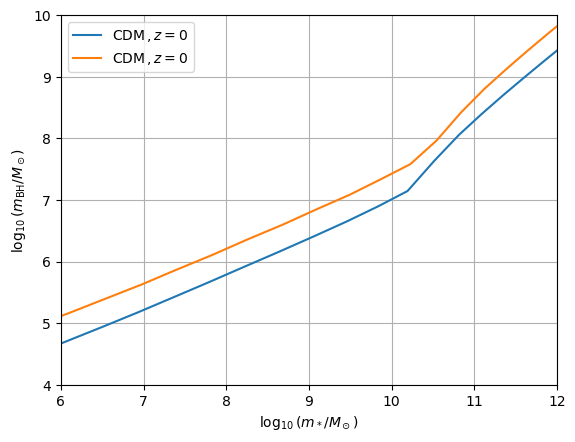

In [ ]:
plt.plot(xval, yval, label=r'$\mathrm{CDM}\, ,z=0$')
plt.plot(xval2, yval2, label=r'$\mathrm{CDM}\, ,z=0$')
plt.xlabel(r'$\log_{10}(m_{\rm *}/M_{\rm \odot})$')
plt.ylabel(r'$\log_{10}(m_{\rm BH}/M_{\rm \odot})$')
plt.xlim(6,12)
plt.ylim(4,10)
plt.grid(True)
plt.legend()
plt.show()

## Merger rate calculator

In [ ]:
# Merger rate computation 
def MR(Δz, mseed, logmvseed, zseed, facbh1, facbh2, fsn, fed, pbh):
    
    nSMBH1 = nMSeed(logm, logmax, dlogm, logmvseed, mseed)
    nS1 = nstar(logm, logmax, dlogm, zseed)
    
    nsteps = int(round(zseed / Δz))
    
    dataEVO = []
    
    for i in range(1, nsteps + 1):
        z_new = zseed - i * Δz
        z_prev = zseed - (i - 1) * Δz
        newdata = ACDM(z_new, z_prev, logm, logmax, dlogm, nSMBH1, nS1, facbh1, facbh2, fsn, fed, pbh)
        nSMBH1, nS1 = newdata[0], newdata[1]
        dataEVO.append([z_new, nSMBH1, nS1])
        
# An interpolating function of the SMBH mass as a function of z and halo mass 
    
    zlist = np.array([dataEVO[i][0] for i in range(len(dataEVO))])
    logmvlist = nl(logm, logmax, dlogm)
    mbhlist = np.empty((zlist.size, logmvlist.size))
    dataR = []
    for i in range(len(dataEVO)):
        for j in range(len(logmvlist)):
            for k in range(len(logmvlist)):
                dataR.append([dataEVO[i][2][j], dataEVO[i][2][k], zlist[i], min(dataEVO[i][2][j]/mseed, 1)*min(dataEVO[i][2][k]/mseed, 1)*Rloglog(10.0 ** logmvlist[j], 10.0 ** logmvlist[k], zlist[i], 10.0 ** (-5.0))])
    fitdatR = np.array([(np.log10(row[0]), np.log10(row[1]) ,row[2],np.log10(row[3])) for row in dataR if row[-1] != 0])
    return fitdatR

In [ ]:
%time mergedat = MR(1, 1e3, 5.5, 20, 1e-2, 1e-20, 1e-3, 1, 1)
logm1 = mergedat[:,0]
logm2 = mergedat[:,1]
z = mergedat[:,2]
logR = mergedat[:,3]
logRinte = LinearNDInterpolator(list(zip(logm1, logm2,z)), logR)

/var/folders/pg/30zt2zh52p546f6kb2dn1w9m0000gn/T/ipykernel_17617/2998926836.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return pfc(δp,𝛔p**2,δm,𝛔m**2)*pfcST(δm,𝛔m**2)/pfcST(δp,𝛔p**2)


CPU times: user 3.58 s, sys: 55.6 ms, total: 3.64 s
Wall time: 3.64 s


In [ ]:
# to make a plot 
z_vals = np.arange(0, 20, 0.5)
r11 = []
r22 = []
r33 = []

for i in z_vals:
    r11.append(logRinte(4, 4, i))
for i in z_vals:
    r22.append(logRinte(5, 5, i))
for i in z_vals:
    r33.append(logRinte(6, 6, i))

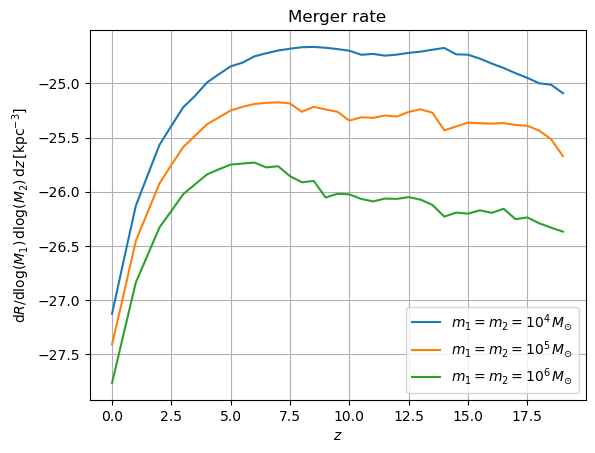

In [ ]:
plt.plot(z_vals, r11, label=r'$m_1=m_2=10^4\, M_{\odot}$')
plt.plot(z_vals, r22, label=r'$m_1=m_2=10^5\, M_{\odot}$')
plt.plot(z_vals, r33, label=r'$m_1=m_2=10^6\, M_{\odot}$')

plt.title(r'Merger rate')
plt.xlabel(r'$z$')
plt.ylabel(r'${\rm d}R/{\rm d} \log(M_1)\,{\rm d} \log(M_2)\, {\rm d} z\,[{\rm kpc}^{-3}]$')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# grids for the SNR 
logm1_vals = np.linspace(1.0, 11.0, 30)
logm2_vals = np.linspace(1.0, 11.0, 30)
logz_vals  = np.linspace(-4.0, np.log10(50.0), 30)

SN_vals_LISA = np.empty((logm1_vals.size, logm2_vals.size, logz_vals.size), dtype=float)
SN_vals_AION = np.empty((logm1_vals.size, logm2_vals.size, logz_vals.size), dtype=float)
SN_vals_AION100m = np.empty((logm1_vals.size, logm2_vals.size, logz_vals.size), dtype=float)


# AION 100m 

for i, logm1 in enumerate(logm1_vals):
    m1 = 10.0**logm1
    for j, logm2 in enumerate(logm2_vals):
        m2 = 10.0**logm2
        Mc, eta = McEta(m1, m2)
        for k, logz in enumerate(logz_vals):
            z = 10.0**logz
            SN_vals_AION100m[i, j, k] = SN(Mc, eta, z, hcAION100m)

# AION 

for i, logm1 in enumerate(logm1_vals):
    m1 = 10.0**logm1
    for j, logm2 in enumerate(logm2_vals):
        m2 = 10.0**logm2
        Mc, eta = McEta(m1, m2)
        for k, logz in enumerate(logz_vals):
            z = 10.0**logz
            SN_vals_AION[i, j, k] = SN(Mc, eta, z, hcAION)
# LISA 

for i, logm1 in enumerate(logm1_vals):
    m1 = 10.0**logm1
    for j, logm2 in enumerate(logm2_vals):
        m2 = 10.0**logm2
        Mc, eta = McEta(m1, m2)
        for k, logz in enumerate(logz_vals):
            z = 10.0**logz
            SN_vals_LISA[i, j, k] = SN(Mc, eta, z, hcLISA)
"""


In [ ]:
np.save("SN_vals_AION100m.npy", SN_vals_AION100m)
np.save("SN_vals_AION.npy", SN_vals_AION)
np.save("SN_vals_LISA.npy", SN_vals_LISA)

In [ ]:
SN_vals_LISA = np.load("SN_vals_AION100m.npy")
SN_vals_AION = np.load("SN_vals_AION.npy")
SN_vals_AION100m = np.load("SN_vals_LISA.npy")

In [ ]:
SNlisa = RegularGridInterpolator((logm1_vals, logm2_vals, logz_vals), SN_vals_LISA,
                                 bounds_error=False, fill_value=None)
SNAION = RegularGridInterpolator((logm1_vals, logm2_vals, logz_vals),  SN_vals_AION,
                                 bounds_error=False, fill_value=None)
SNAION100m = RegularGridInterpolator((logm1_vals, logm2_vals, logz_vals), SN_vals_AION100m,
                                 bounds_error=False, fill_value=None)

In [ ]:
#Functions related to the merger rate 

def Nmerge(sn, mseed, R, pbh, zs):
    integrand = lambda logm1, logm2, logz: (
        (10.0**logz) * DVc(10.0**logz) / (1.0 + 10.0**logz)
        * pdet(sn([logm1, logm2, logz])[0] / 8.0)
        * (10.0**float(R(logm1, logm2, 10**logz)))
    )
    bounds = [
        (np.log10(mseed), 10.0),
        (np.log10(mseed), 10.0),
        (-4.0, np.log10(zs)),
    ]
    return year * pbh * np.log(10.0) * nquad(integrand, bounds, opts={"epsabs": 1})

def datmerg(Nevents, sn, mseed, R, pbh, zs):
    logm1_grid = np.linspace(np.log10(mseed), 10.0, 12 + 1)
    logm2_grid = np.linspace(np.log10(mseed), 10.0, 12 + 1)
    logz_grid  = np.linspace(-4.0, np.log10(zs), 20 + 1)
    out = []
    for logm1 in logm1_grid:
        for logm2 in logm2_grid:
            for logz in logz_grid:
                val = (Nevents**(-1.0) * year * np.log(10.0) * pbh * (10.0**logz)
                       * DVc(10.0**logz) / (1.0 + 10.0**logz)
                       * pdet(sn([logm1, logm2, logz])[0]/ 8.0)
                       * (10.0**R(logm1, logm2, logz)))
                out.append([logm1, logm2, logz, val])
    return np.array(out)

In [ ]:
class _PDF3D:
    
    def __init__(self, points, values, bounds):
        self.bounds = bounds  # ((logm1_min, logm1_max), (logm2_min, logm2_max), (logz_min, logz_max))
        self.interp = interpolate.LinearNDInterpolator(points, values, fill_value=0.0)
        self._fmax = float(np.nanmax(values)) if np.isfinite(values).all() else float(np.nanmax(np.where(np.isfinite(values), values, 0.0)))
        if not np.isfinite(self._fmax) or self._fmax <= 0.0:
            self._fmax = 1.0

    def __call__(self, logm1, logm2, logz):
        return float(self.interp((logm1, logm2, logz)))

    def rvs(self, size):
        n = int(size)
        samples = []
        (a1, b1), (a2, b2), (az, bz) = self.bounds
        rng = np.random.default_rng()
        while len(samples) < n:
            x = rng.uniform(a1, b1)
            y = rng.uniform(a2, b2)
            z = rng.uniform(az, bz)
            fval = self(x, y, z)
            if fval <= 0.0:
                continue
            u = rng.uniform(0.0, self._fmax)
            if u <= fval:
                samples.append([x, y, z])
        return np.array(samples)

def Pdist(Nevents, sn, mseed, R, pbh, zs):
    
    data = datmerg(Nevents, sn, mseed, R, pbh, zs)
    points = data[:, :3]
    values = data[:, 3]
    logm1_min, logm1_max = np.log10(mseed), 10.0
    logm2_min, logm2_max = np.log10(mseed), 10.0
    logz_min, logz_max = float(np.min(points[:, 2])), float(np.max(points[:, 2]))
    return _PDF3D(points, values, ((logm1_min, logm1_max), (logm2_min, logm2_max), (logz_min, logz_max)))

def Merges(events, PDF):
    a = np.random.poisson(lam=max(events, 0))
    return PDF.rvs(size=a)

In [ ]:
# event generator 

def EvenCDM(Δz, mseed, logmvseed, zseed, facbh1, facbh2, fsn, fed, pbh, σ1, sn):
    
    nSMBH1 = nMSeed(logm, logmax, dlogm, logmvseed, mseed)
    nS1 = nstar(logm, logmax, dlogm, zseed)

    nsteps = int(round(zseed / Δz))

    dataEVO = []
    
    dataEVO.append([zseed, nSMBH1, nS1])

    points_f1 = []
    values_f1 = []

    for i in range(1, nsteps + 1):
        z_new = zseed - i * Δz
        z_prev = zseed - (i - 1) * Δz

        newdata = ACDM(z_new, z_prev, logm, logmax, dlogm, nSMBH1, nS1,  facbh1, facbh2, fsn, fed, pbh)

        nSMBH1, nS1 = newdata[0], newdata[1]

        dataEVO.append([z_new, nSMBH1, nS1])
    
    for i in range(nsteps+1):
        z_i = dataEVO[i][0]
        x_grid = nl(logm, logmax, dlogm)
        nS_vals = np.log10(np.asarray(dataEVO[i][2], dtype=float))
        for x, v in zip(x_grid, nS_vals):
            points_f1.append([z_i, x])
            values_f1.append(v)
            
    f1_interp = interpolate.LinearNDInterpolator(np.asarray(points_f1), np.asarray(values_f1), fill_value=np.nan)

    def f1(z, x):
        return float(f1_interp((z, x)))

    z_list = [zseed - (i + 1) * Δz for i in range(nsteps)]
    x_solutions = []
    for z_i in z_list:
        def g(x):
            return f1(z_i, x) - np.log10(mseed)
        try:
            sol = optimize.root_scalar(g, bracket=(logm, logmax), method="brentq").root
        except Exception:
            sol = np.nan
        x_solutions.append(sol)
    z_arr = np.asarray(z_list, dtype=float)
    x_arr = np.asarray(x_solutions, dtype=float)
    mask = np.isfinite(x_arr)
    if np.count_nonzero(mask) >= 2:
        f2_interp = interpolate.interp1d(z_arr[mask], x_arr[mask], kind='linear', bounds_error=False, fill_value="extrapolate")
    else:
        f2_interp = lambda z: float('nan')

    def f2(z):
        return float(f2_interp(z)) if callable(f2_interp) else float('nan')

    # Rnum: 3D interpolation over (logmbh1, logmbh2, logz) of log10[R(...)]
    logm1_grid = np.linspace(np.log10(mseed), 10.0, 12 + 1)
    logm2_grid = np.linspace(np.log10(mseed), 10.0, 12 + 1)
    logz_grid  = np.linspace(-4.0, np.log10(zseed), 20 + 1)

    pts_R = []
    vals_R = []
    for logmbh1 in logm1_grid:
        for logmbh2 in logm2_grid:
            for logz in logz_grid:
                z_lin = 10.0**logz
                val = np.log10(R(logmbh1, logmbh2, z_lin, σ1, f1, f2(z_lin), logmax))
                pts_R.append([logmbh1, logmbh2, logz])
                vals_R.append(val)
    Rnum_interp = interpolate.LinearNDInterpolator(np.asarray(pts_R), np.asarray(vals_R), fill_value=0.0)

    def Rnum(logmbh1, logmbh2, logz):
        return float(Rnum_interp((logmbh1, logmbh2, logz)))

    nm = Nmerge(sn, mseed, Rnum, pbh, zseed)
    pdfm = Pdist(nm, sn, mseed, Rnum, pbh, zseed)
    return nm, Merges(nm, pdfm), dataEVO
